In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import ipywidgets as widgets
from IPython.display import display

# Define the second order system dynamics (mass-spring-damper with PID controller)
def system_dynamics(y, t, Kp, Ki, Kd, setpoint):
    x, v, integral = y  # Position, velocity, and integrated error
    error = setpoint - x
    derivative = -v  # Derivative of error (d(error)/dt)
    u = Kp * error + Ki * integral + Kd * derivative

    # Plant parameters
    m = 1.0   # mass
    c = 1.0  # damping coefficient
    k = 0.5   # stiffness

    dxdt = v
    dvdt = (u - c*v - k*x) / m
    dintdt = error  # Integrate the error

    return [dxdt, dvdt, dintdt]

# Simulation function
def simulate(Kp, Ki, Kd, setpoint):
    t = np.linspace(0, 10, 1000)
    y0 = [0, 0, 0]
    sol = odeint(system_dynamics, y0, t, args=(Kp, Ki, Kd, setpoint))
    x = sol[:, 0]

    plt.figure(figsize=(10, 5))
    plt.plot(t, x, label='System Output')
    plt.axhline(y=setpoint, color='r', linestyle='--', label='Setpoint')
    plt.xlabel('Time')
    plt.ylabel('Position')
    plt.title('Second Order PID Control Simulation')
    plt.legend()
    plt.grid(True)
    plt.show()

# Create interactive widgets
Kp_slider = widgets.FloatSlider(value=3.5, min=0.0, max=5.0, step=0.1, description='Kp:')
Ki_slider = widgets.FloatSlider(value=0.0, min=0.0, max=5.0, step=0.1, description='Ki:')
Kd_slider = widgets.FloatSlider(value=0.0, min=0.0, max=5.0, step=0.1, description='Kd:')
setpoint_slider = widgets.FloatSlider(value=1.0, min=0.0, max=10.0, step=0.1, description='Setpoint:')

# Display interactive widgets
ui = widgets.VBox([Kp_slider, Ki_slider, Kd_slider, setpoint_slider])
out = widgets.interactive_output(simulate, {'Kp': Kp_slider, 'Ki': Ki_slider, 'Kd': Kd_slider, 'setpoint': setpoint_slider})

display(ui, out)

Output()

## System Dynamics and PID Controller

The system is defined by a mass-spring-damper plant with a PID controller.

Let:
- $x$ be the position.
- $v = \frac{dx}{dt}$ be the velocity.
- $I$ be the integral of the error.

The PID controller is given by:
$$
u = K_p \, e + K_i \, I + K_d \, \frac{de}{dt}
$$

where the error is defined as:
$$
e = \text{setpoint} - x
$$
and its derivative is:
$$
\frac{de}{dt} = -v \quad \text{(since } \frac{de}{dt} = 0 - \frac{dx}{dt}\text{)}
$$

The plant dynamics are described by:
$$
\frac{dx}{dt} = v
$$
$$
\frac{dv}{dt} = \frac{u - c\,v - k\,x}{m}
$$

The evolution of the integral of the error is:
$$
\frac{dI}{dt} = e = \text{setpoint} - x
$$

Substituting $u$ into the acceleration equation, we obtain:
$$
\frac{dv}{dt} = \frac{K_p\,(\text{setpoint} - x) + K_i\,I - K_d\,v - c\,v - k\,x}{m}
$$


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



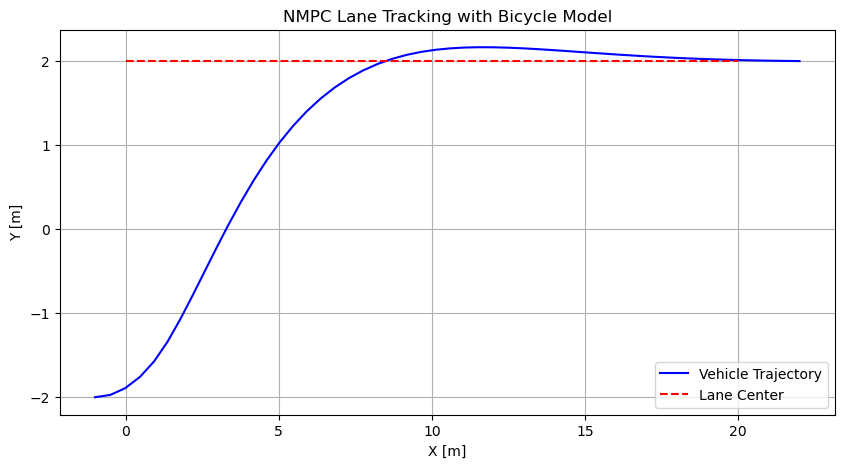

In [6]:

import numpy as np
import casadi as ca
import matplotlib.pyplot as plt

# --------------------------
# Parameters & Model Settings
# --------------------------
L = 2.5           # Wheelbase [m]
dt = 0.1          # Discrete time step [s]
N = 20           # Prediction horizon length

# --------------------------
# State and Control Variables
# --------------------------
# States: [X, Y, psi, v]
n_states = 4
# Controls: [delta, a] (steering angle, acceleration)
n_controls = 2

# Define symbolic variables for states and controls
x = ca.SX.sym('x')
y = ca.SX.sym('y')
psi = ca.SX.sym('psi')
v = ca.SX.sym('v')
states = ca.vertcat(x, y, psi, v)

# controls: steering angle (delta) and acceleration (a)
delta = ca.SX.sym('delta')
a = ca.SX.sym('a')
controls = ca.vertcat(delta, a)

# --------------------------
# Bicycle Model Dynamics (Continuous Time)
# --------------------------
rhs = ca.vertcat(
    v * ca.cos(psi),      # dX/dt
    v * ca.sin(psi),      # dY/dt
    (v / L) * ca.tan(delta),# dpsi/dt
    a                     # dv/dt
)

# Create a function for the dynamics
f = ca.Function('f', [states, controls], [rhs])

# --------------------------
# Discretize Dynamics using 4th Order Runge-Kutta
# --------------------------
def integrate_rk4(x0, u, dt):
    k1 = f(x0, u)
    k2 = f(x0 + dt/2 * k1, u)
    k3 = f(x0 + dt/2 * k2, u)
    k4 = f(x0 + dt * k3, u)
    return x0 + dt/6 * (k1 + 2*k2 + 2*k3 + k4)

# --------------------------
# Setup NMPC Optimization Problem
# --------------------------
# Decision variables for states and controls over the horizon
X = ca.SX.sym('X', n_states, N+1)   # predicted state trajectory
U = ca.SX.sym('U', n_controls, N)   # control trajectory

# Parameter vector: includes initial state and reference trajectory.
# Here, P = [x0, y0, psi0, v0, x_ref0, y_ref0, x_ref1, y_ref1, ..., x_refN, y_refN]
P = ca.SX.sym('P', n_states + 2*(N+1))

# Cost function and constraints container
cost = 0
g = []

# --------------------------
# Cost Function Weights
# --------------------------
# Weights for tracking error (only position error in this example)
Q_pos = np.diag([0, 10])
# Weight for control effort
R = np.diag([100, 100])

# --------------------------
# Build the Cost Function and Dynamic Constraints
# --------------------------
# 1. Initial state constraint: X[:,0] == initial state (first 4 entries of P)
g.append(X[:, 0] - P[0:n_states])

# 2. Build the trajectory over the horizon
for k in range(N):
    # Get the reference for step k+1 from P:
    # P structure: [x0, y0, psi0, v0, x_ref0, y_ref0, x_ref1, y_ref1, ..., x_refN, y_refN]
    x_ref = P[n_states + 2*k]      # x_ref for step k
    y_ref = P[n_states + 2*k + 1]    # y_ref for step k

    # Tracking cost (squared Euclidean distance in the XY-plane)
    pos_error = ca.vertcat(X[0, k+1] - x_ref, X[1, k+1] - y_ref)
    cost = cost + ca.mtimes([pos_error.T, Q_pos, pos_error])

    # Control effort cost
    cost = cost + ca.mtimes([U[:, k].T, R, U[:, k]])

    # Dynamics constraint: X[:,k+1] = integrate_rk4(X[:,k], U[:,k], dt)
    x_next = integrate_rk4(X[:, k], U[:, k], dt)
    g.append(X[:, k+1] - x_next)

# Flatten constraints into a single vector
g = ca.vertcat(*g)

# --------------------------
# Decision Variables Vector
# --------------------------
OPT_variables = ca.vertcat(
    ca.reshape(X, -1, 1),
    ca.reshape(U, -1, 1)
)

# --------------------------
# NMPC Problem Definition
# --------------------------
nlp_prob = {
    'f': cost,
    'x': OPT_variables,
    'p': P,
    'g': g
}

# Options for the NLP solver (IPOPT in this case)
opts = {'ipopt.print_level': 0, 'print_time': 0}
solver = ca.nlpsol('solver', 'ipopt', nlp_prob, opts)

# --------------------------
# Set Constraints Bounds
# --------------------------
# Equality constraints: g = 0
lbg = np.zeros(g.shape)
ubg = np.zeros(g.shape)

# Decision variables bounds:
# For states: no hard bounds in this example (set to large numbers)
nX = n_states * (N+1)
nU = n_controls * N

lbX = -np.inf * np.ones((nX, 1))
ubX =  np.inf * np.ones((nX, 1))

# For controls: set some bounds (example: steering angle and acceleration limits)
# Steering angle [rad] limits and acceleration [m/s^2] limits.
lbU = np.tile(np.array([[-0.5], [-1.0]]), (N, 1))
ubU = np.tile(np.array([[0.5], [1.0]]), (N, 1))

lb = np.vstack((lbX, lbU))
ub = np.vstack((ubX, ubU))

# --------------------------
# NMPC Simulation Setup
# --------------------------
# Initial state
x0 = np.array([-1, -2, 0, 5])  # starting at origin, heading 0, speed 5 m/s

# Create a simple lane center: a straight line offset in y-direction (e.g., y = 2) for demonstration.
# Here we generate reference for N+1 steps.
ref_x = np.linspace(0, 20, N+1)
ref_y = 2 * np.ones(N+1)

# Storage for simulation
sim_time = 5  # seconds
sim_steps = int(sim_time/dt)
state_history = [x0]
u_history = []

# Initial guess for optimization variables (states and controls)
x_init = np.tile(x0.reshape(-1, 1), (1, N+1))
u_init = np.zeros((n_controls, N))
init_guess = np.vstack((x_init.reshape(-1, 1), u_init.reshape(-1, 1)))

# --------------------------
# NMPC Loop
# --------------------------
current_state = x0.copy()
for t in range(sim_steps):
    # Build the parameter vector for the current optimization
    # P: [current state, ref_x[0], ref_y[0], ..., ref_x[N], ref_y[N]]
    p = np.concatenate((current_state, np.vstack((ref_x, ref_y)).reshape(-1, order='F')))

    # Solve the NMPC problem
    sol = solver(x0=init_guess, p=p, lbx=lb, ubx=ub, lbg=lbg, ubg=ubg)
    sol_val = sol['x'].full().flatten()

    # Extract the control sequence and state trajectory
    X_sol = sol_val[0:nX].reshape((n_states, N+1))
    U_sol = sol_val[nX:].reshape((n_controls, N))

    # Apply the first control input
    u_applied = U_sol[:, 0]
    u_history.append(u_applied)

    # Simulate the system forward using the applied control and RK4 integration
    current_state = integrate_rk4(current_state, u_applied, dt).full().flatten()
    state_history.append(current_state)

    # Warm start: use the solved trajectory shifted in time
    x_init = np.hstack((X_sol[:, 1:], X_sol[:, -1:]))
    u_init = np.hstack((U_sol[:, 1:], U_sol[:, -1:]))
    init_guess = np.vstack((x_init.reshape(-1, 1), u_init.reshape(-1, 1)))

# --------------------------
# Plotting the Results
# --------------------------
state_history = np.array(state_history)
plt.figure(figsize=(10, 5))
plt.plot(state_history[:, 0], state_history[:, 1], 'b-', label='Vehicle Trajectory')
plt.plot(ref_x, ref_y, 'r--', label='Lane Center')
plt.xlabel('X [m]')
plt.ylabel('Y [m]')
plt.title('NMPC Lane Tracking with Bicycle Model')
plt.legend()
plt.grid(True)
plt.show()


In [7]:
import casadi as ca
import numpy as np

# 1) Parameter p for current state (X, Y, psi, v, delta)
p = ca.SX.sym('p', 5)
X_, Y_, psi_, v_, delta_ = p[0], p[1], p[2], p[3], p[4]

# 2) Decision variables
a_ = ca.SX.sym('a')
dot_delta_ = ca.SX.sym('dot_delta')
eps_lane = ca.SX.sym('eps_lane')
eps_speed = ca.SX.sym('eps_speed')
eps_obs = ca.SX.sym('eps_obs')
opt_vars = ca.vertcat(a_, dot_delta_, eps_lane, eps_speed, eps_obs)

# 3) Build f, B in terms of (X_,Y_,psi_,v_,delta_)
L = 2.5
f = ca.vertcat(
    v_*ca.cos(psi_),
    v_*ca.sin(psi_),
    (v_/L)*ca.tan(delta_),
    0,
    0
)
B = ca.DM([
    [0, 0],
    [0, 0],
    [0, 0],
    [1, 0],
    [0, 1]
])

# 4) Define your CLFs/CBF
# Example: Speed CLF
v_ref = 10.0
V_speed = (v_ - v_ref)**2
gradV_speed = ca.gradient(V_speed, p)
dotV_speed = gradV_speed.T@f + gradV_speed.T@B@ca.vertcat(a_, dot_delta_)

gamma_speed = 2.0
g_speed = dotV_speed + gamma_speed*V_speed - eps_speed
# constraint -> g_speed <= 0

# similarly define lane/obs stuff ...
# g_lane, g_obs, etc.

# 5) Cost
cost = a_**2 + dot_delta_**2 + 100*eps_speed**2  # plus any other terms

g = [g_speed]  # add lane, obs constraints here
G = ca.vertcat(*g)

# 6) Create NLP dict with 'p': p
nlp_prob = {
    'x': opt_vars,
    'p': p,
    'f': cost,
    'g': G
}

opts = {'print_time': 0, 'ipopt.print_level': 0}
solver = ca.nlpsol('solver', 'ipopt', nlp_prob, opts)

# 7) Bounds on opt_vars
lbx = [ -3.0, -1.0,  0.0,  0.0,  0.0]
ubx = [  3.0,  1.0, 1e4, 1e4, 1e4]
lbg = [-ca.inf] # or multiple constraints if you have many
ubg = [0.0]

# 8) Solve for a sample "current_state"
x_curr = np.array([0, 0, 0, 8, 0])  # [X, Y, psi, v, delta]

sol = solver(
    x0   = np.zeros(opt_vars.numel()),  # initial guess
    p    = x_curr,                      # pass the param
    lbx  = lbx,
    ubx  = ubx,
    lbg  = lbg,
    ubg  = ubg
)

solution = sol['x'].full().flatten()
a_opt = solution[0]
dot_delta_opt = solution[1]
print("a_opt:", a_opt, " dot_delta_opt:", dot_delta_opt)


a_opt: 1.998750778049711  dot_delta_opt: 0.0
